# Razvoj modela

In [1]:
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
import numpy as np
import warnings
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from tensorflow.keras import layers, models as tf_models, callbacks
from sklearn.preprocessing import PolynomialFeatures
import datetime

warnings.filterwarnings('ignore')

### Učitavanje podataka

In [2]:
cities_df = pd.read_json('dataset/city_basic_stats.json')
cities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   n                             21 non-null     int64  
 1   m                             21 non-null     int64  
 2   k_avg                         21 non-null     float64
 3   edge_length_total             21 non-null     float64
 4   edge_length_avg               21 non-null     float64
 5   streets_per_node_avg          21 non-null     float64
 6   streets_per_node_counts       21 non-null     object 
 7   streets_per_node_proportions  21 non-null     object 
 8   intersection_count            21 non-null     int64  
 9   street_length_total           21 non-null     float64
 10  street_segment_count          21 non-null     int64  
 11  street_length_avg             21 non-null     float64
 12  circuity_avg                  21 non-null     float64
 13  self_lo

In [3]:
df = pd.read_csv('dataset/deliverytime_with_route_lengths.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35159 entries, 0 to 35158
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0.1                 35159 non-null  int64  
 1   Unnamed: 0                   35159 non-null  int64  
 2   ID                           35159 non-null  object 
 3   Delivery_person_ID           35159 non-null  object 
 4   Delivery_person_Age          35159 non-null  int64  
 5   Delivery_person_Ratings      35159 non-null  float64
 6   Restaurant_latitude          35159 non-null  float64
 7   Restaurant_longitude         35159 non-null  float64
 8   Delivery_location_latitude   35159 non-null  float64
 9   Delivery_location_longitude  35159 non-null  float64
 10  Weatherconditions            35159 non-null  object 
 11  Road_traffic_density         35159 non-null  object 
 12  Vehicle_condition            35159 non-null  int64  
 13  Type_of_order   

## Priprema podataka

### Spajanje podatkovnog skupa dostava s podatkovnim skupom statistika gradova

In [4]:
merged_df = pd.merge(df, cities_df, on='city_code')
merged_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'ID', 'Delivery_person_ID',
       'Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Weatherconditions',
       'Road_traffic_density', 'Vehicle_condition', 'Type_of_order',
       'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City',
       'Time_taken(min)', 'Datetime_Ordered', 'Datetime_Picked',
       'distance(km)', 'city_code', 'Restaurant_node_id', 'Delivery_node_id',
       'shortest_path', 'shortest_path_length', 'n', 'm', 'k_avg',
       'edge_length_total', 'edge_length_avg', 'streets_per_node_avg',
       'streets_per_node_counts', 'streets_per_node_proportions',
       'intersection_count', 'street_length_total', 'street_segment_count',
       'street_length_avg', 'circuity_avg', 'self_loop_proportion',
       'node_density_km', 'intersection_density_km', 'edge_density_km',
       'street_density_km'],
     

### Heurističko mijenjanje kategoričkih vrijednosti numeričkima

In [5]:
print(merged_df['Type_of_order'].unique())
print(merged_df['Type_of_vehicle'].unique())
print(merged_df['Weatherconditions'].unique())
print(merged_df['Road_traffic_density'].unique())
print(merged_df['City'].unique())

merged_df['Type_of_order'].replace(
    ['snack', 'drinks', 'meal', 'buffet'],
    [1, 1, 5, 5], 
    inplace=True
)

merged_df['Type_of_vehicle'].replace(
    ['motorcycle', 'scooter', 'electric_scooter', 'bicycle'],
    [5, 5, 3, 0.5], 
    inplace=True
)

merged_df['Weatherconditions'].replace(
    ['Sunny', 'Stormy', 'Sandstorms', 'Cloudy', 'Fog', 'Windy'],
    [0.5, 2, 2, 3, 3, 2], 
    inplace=True
)


merged_df['Road_traffic_density'].replace(
    ['High ', 'Jam ', 'Low ', 'Medium '],
    [2, 3, 0.5, 1], 
    inplace=True
)

merged_df['City'].replace(
    ['Urban ', 'Metropolitian ', 'Semi-Urban '],
    [2, 3, 1], 
    inplace=True
)


['snack' 'drinks' 'meal' 'buffet']
['motorcycle' 'scooter' 'electric_scooter']
['Sunny' 'Cloudy' 'Sandstorms' 'Fog' 'Stormy' 'Windy']
['High ' 'Low ' 'Medium ' 'Jam ']
['Urban ' 'Metropolitian ' 'Semi-Urban ']


In [6]:
merged_df['Datetime_Ordered'] = pd.to_datetime(merged_df['Datetime_Ordered'])
merged_df['Datetime_Picked'] = pd.to_datetime(merged_df['Datetime_Picked'])

merged_df["Order_month"] = merged_df['Datetime_Ordered'].dt.month
merged_df["Order_hour"] = merged_df['Datetime_Ordered'].dt.hour
merged_df["Picked_month"] = merged_df['Datetime_Picked'].dt.month
merged_df["Picked_hour"] = merged_df['Datetime_Picked'].dt.hour
merged_df["Day_of_week"] = merged_df['Datetime_Ordered'].dt.day_of_week + 1

In [7]:
merged_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'ID', 'Delivery_person_ID',
       'Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Weatherconditions',
       'Road_traffic_density', 'Vehicle_condition', 'Type_of_order',
       'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City',
       'Time_taken(min)', 'Datetime_Ordered', 'Datetime_Picked',
       'distance(km)', 'city_code', 'Restaurant_node_id', 'Delivery_node_id',
       'shortest_path', 'shortest_path_length', 'n', 'm', 'k_avg',
       'edge_length_total', 'edge_length_avg', 'streets_per_node_avg',
       'streets_per_node_counts', 'streets_per_node_proportions',
       'intersection_count', 'street_length_total', 'street_segment_count',
       'street_length_avg', 'circuity_avg', 'self_loop_proportion',
       'node_density_km', 'intersection_density_km', 'edge_density_km',
       'street_density_km', 'Order

### Izabir numeričkih vrijednosti iz podatkovnog skupa

In [8]:
X_numeric = merged_df.select_dtypes(include='number')
X_numeric = X_numeric.drop(['Time_taken(min)', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)
X_numeric.columns

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Weatherconditions',
       'Road_traffic_density', 'Vehicle_condition', 'Type_of_order',
       'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City',
       'distance(km)', 'Restaurant_node_id', 'Delivery_node_id',
       'shortest_path_length', 'n', 'm', 'k_avg', 'edge_length_total',
       'edge_length_avg', 'streets_per_node_avg', 'intersection_count',
       'street_length_total', 'street_segment_count', 'street_length_avg',
       'circuity_avg', 'self_loop_proportion', 'node_density_km',
       'intersection_density_km', 'edge_density_km', 'street_density_km',
       'Order_month', 'Order_hour', 'Picked_month', 'Picked_hour',
       'Day_of_week'],
      dtype='object')

### 'Train-validation-test' podjela, polinomijalna transformacija i standardizacija

In [9]:
target_column = 'Time_taken(min)'

X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, 
    merged_df[target_column], 
    test_size=0.2
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.2
)

In [10]:
degree = 2

selected_attributes = [
    'Delivery_person_Age', 'Delivery_person_Ratings', 'Weatherconditions',
    'Road_traffic_density', 'Vehicle_condition', 'multiple_deliveries', 
    'Festival', 'City', 'shortest_path_length', 'intersection_density_km', 
    'self_loop_proportion', 'circuity_avg', 'Order_hour', 'Picked_hour'
]

poly = PolynomialFeatures(degree=degree)
X_train_poly = pd.DataFrame(poly.fit_transform(X_train[selected_attributes]), columns=poly.get_feature_names_out(X_train[selected_attributes].columns))
X_val_poly = pd.DataFrame(poly.fit_transform(X_val[selected_attributes]), columns=poly.get_feature_names_out(X_val[selected_attributes].columns))
X_test_poly = pd.DataFrame(poly.fit_transform(X_test[selected_attributes]), columns=poly.get_feature_names_out(X_test[selected_attributes].columns))

extended_df = pd.concat([X_train, X_train_poly, y_train], axis=1)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

scaler = StandardScaler()
X_train_scaled_poly = scaler.fit_transform(X_train_poly)
X_val_scaled_poly = scaler.transform(X_val_poly)
X_test_scaled_poly = scaler.transform(X_test_poly)

## Bazna struktura neuronske mreže

In [12]:
def create_neural_network(input_shape, hidden_layer_sizes=[], act_funs=[], output_size=1):
    """Creates untrained linear regresion model with specified sizes of hidden layers 
    and specified activation functions between layers.
    """
    nn = tf_models.Sequential()

    nn.add(layers.InputLayer(input_shape=input_shape))

    for i in range(len(hidden_layer_sizes)):
        units = hidden_layer_sizes[i]
        activation_fun = act_funs[i]
        nn.add(layers.Dense(units, activation=activation_fun))

    nn.add(layers.Dense(output_size, activation='linear'))  # Adjust activation function as needed

    return nn

### Jednostavna linearna regresija (bez skrivenih slojeva)

In [13]:
input_size = X_train_scaled.shape[1]

input_shape = (input_size,)
neural_network = create_neural_network(input_shape, [], [])

neural_network.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 40        
                                                                 
Total params: 40 (160.00 Byte)
Trainable params: 40 (160.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
neural_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
              loss='mse')

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5)

neural_network.fit(
    X_train_scaled, y_train, 
    epochs=300, batch_size=1024, 
    validation_data=(X_val_scaled, y_val),
    callbacks=[reduce_lr, early_stopping]
)

predictions = neural_network.predict(X_test_scaled)

Epoch 1/300

22/22 [==============================] - 1s 9ms/step - loss: 782.8168 - val_loss: 761.1772 - lr: 0.0100
Epoch 2/300
22/22 [==============================] - 0s 3ms/step - loss: 759.7762 - val_loss: 740.7491 - lr: 0.0100
Epoch 3/300
22/22 [==============================] - 0s 3ms/step - loss: 740.2266 - val_loss: 722.8514 - lr: 0.0100
Epoch 4/300
22/22 [==============================] - 0s 3ms/step - loss: 723.1229 - val_loss: 706.6508 - lr: 0.0100
Epoch 5/300
22/22 [==============================] - 0s 3ms/step - loss: 707.4722 - val_loss: 691.8558 - lr: 0.0100
Epoch 6/300
22/22 [==============================] - 0s 3ms/step - loss: 693.0145 - val_loss: 678.0744 - lr: 0.0100
Epoch 7/300
22/22 [==============================] - 0s 3ms/step - loss: 679.3837 - val_loss: 665.0207 - lr: 0.0100
Epoch 8/300
22/22 [==============================] - 0s 3ms/step - loss: 666.6180 - val_loss: 652.4501 - lr: 0.0100
Epoch 9/300
22/22 [==============================] - 0s 3ms/step - loss

In [15]:
predictions = predictions.reshape((predictions.shape[0]))
mse = mean_squared_error(y_test, predictions.T)
average_relative_difference = np.mean(abs(y_test - predictions.T) / y_test)
print(f'Average Relative Difference: {average_relative_difference}')
print(f'Mean Squared Error: {mse}')
print(f'R2_score = {r2_score(y_test, predictions)}')

Average Relative Difference: 0.20481709490241856
Mean Squared Error: 36.553635043665196
R2_score = 0.571891050722696


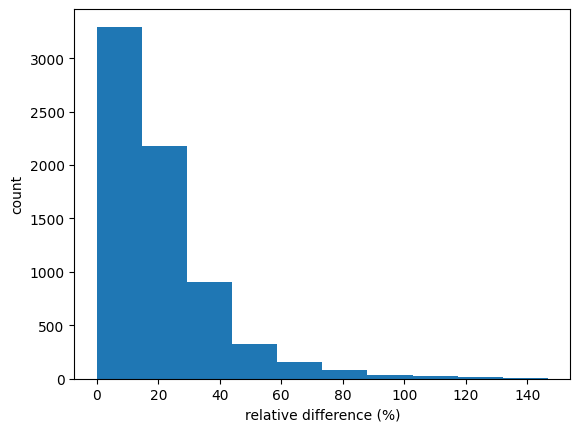

In [16]:
sorted_diffs = np.sort(abs(y_test - predictions.T) / y_test) * 100
plt.hist(sorted_diffs)
plt.xlabel('relative difference (%)')
plt.ylabel('count')
plt.show()

### Jednostavna linearna regresija (bez skrivenih slojeva) sa polinomijalno transformiranim značajkama 

In [17]:
input_size = X_train_scaled_poly.shape[1]

input_shape = (input_size,)
neural_network = create_neural_network(input_shape, [], [])

neural_network.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 121       
                                                                 
Total params: 121 (484.00 Byte)
Trainable params: 121 (484.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
neural_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
              loss='mse')

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5)

neural_network.fit(
    X_train_scaled_poly, y_train, 
    epochs=300, batch_size=1024, 
    validation_data=(X_val_scaled_poly, y_val),
    callbacks=[reduce_lr, early_stopping]
)

predictions = neural_network.predict(X_test_scaled_poly)

Epoch 1/300


22/22 [==============================] - 0s 8ms/step - loss: 762.1467 - val_loss: 731.9682 - lr: 0.0100
Epoch 2/300
22/22 [==============================] - 0s 3ms/step - loss: 731.1776 - val_loss: 714.5160 - lr: 0.0100
Epoch 3/300
22/22 [==============================] - 0s 3ms/step - loss: 716.0529 - val_loss: 701.5215 - lr: 0.0100
Epoch 4/300
22/22 [==============================] - 0s 3ms/step - loss: 704.0244 - val_loss: 689.7394 - lr: 0.0100
Epoch 5/300
22/22 [==============================] - 0s 3ms/step - loss: 692.0544 - val_loss: 678.4059 - lr: 0.0100
Epoch 6/300
22/22 [==============================] - 0s 3ms/step - loss: 680.8082 - val_loss: 667.2024 - lr: 0.0100
Epoch 7/300
22/22 [==============================] - 0s 3ms/step - loss: 669.5236 - val_loss: 656.1531 - lr: 0.0100
Epoch 8/300
22/22 [==============================] - 0s 3ms/step - loss: 658.5407 - val_loss: 645.4943 - lr: 0.0100
Epoch 9/300
22/22 [==============================] - 0s 3ms/step - loss: 647.7903 - 

In [19]:
predictions = predictions.reshape((predictions.shape[0]))
mse = mean_squared_error(y_test, predictions.T)
average_relative_difference = np.mean(abs(y_test - predictions.T) / y_test)
print(f'Average Relative Difference: {average_relative_difference}')
print(f'Mean Squared Error: {mse}')
print(f'R2_score = {r2_score(y_test, predictions)}')

Average Relative Difference: 0.1807754039558531
Mean Squared Error: 29.60471028830824
R2_score = 0.653275484092161


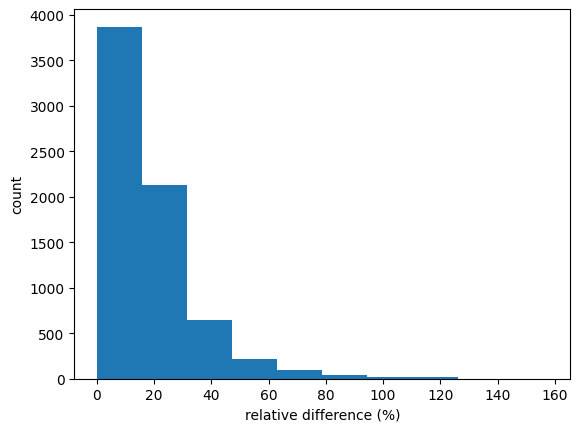

In [20]:
sorted_diffs = np.sort(abs(y_test - predictions.T) / y_test) * 100
plt.hist(sorted_diffs)
plt.xlabel('relative difference (%)')
plt.ylabel('count')
plt.show()

### Linearna regresija sa skrivenim slojevima

In [21]:
input_size = X_train_scaled.shape[1]

input_shape = (input_size,)
hidden_layer_sizes = [64, 32, 16]
activation_functions = ['relu', 'sigmoid', 'relu']

neural_network = create_neural_network(input_shape, hidden_layer_sizes, activation_functions)

neural_network.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                2560      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5185 (20.25 KB)
Trainable params: 5185 (20.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
neural_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
              loss='mse')

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5)

neural_network.fit(
    X_train_scaled, y_train, 
    epochs=300, batch_size=1024, 
    validation_data=(X_val_scaled, y_val),
    callbacks=[reduce_lr, early_stopping]
)

predictions = neural_network.predict(X_test_scaled)

Epoch 1/300
22/22 [==============================] - 1s 10ms/step - loss: 390.4366 - val_loss: 82.1637 - lr: 0.0100
Epoch 2/300
22/22 [==============================] - 0s 4ms/step - loss: 89.1878 - val_loss: 73.2515 - lr: 0.0100
Epoch 3/300
22/22 [==============================] - 0s 4ms/step - loss: 66.0761 - val_loss: 56.7352 - lr: 0.0100
Epoch 4/300
22/22 [==============================] - 0s 4ms/step - loss: 51.6766 - val_loss: 45.5245 - lr: 0.0100
Epoch 5/300
22/22 [==============================] - 0s 4ms/step - loss: 41.5177 - val_loss: 37.6899 - lr: 0.0100
Epoch 6/300
22/22 [==============================] - 0s 4ms/step - loss: 36.4989 - val_loss: 34.8239 - lr: 0.0100
Epoch 7/300
22/22 [==============================] - 0s 4ms/step - loss: 33.9132 - val_loss: 32.7543 - lr: 0.0100
Epoch 8/300
22/22 [==============================] - 0s 4ms/step - loss: 32.0329 - val_loss: 31.0166 - lr: 0.0100
Epoch 9/300
22/22 [==============================] - 0s 3ms/step - loss: 30.0919 - val

In [23]:
predictions = predictions.reshape((predictions.shape[0]))
mse = mean_squared_error(y_test, predictions.T)
average_relative_difference = np.mean(abs(y_test - predictions.T) / y_test)
print(f'Average Relative Difference: {average_relative_difference}')
print(f'Mean Squared Error: {mse}')
print(f'R2_score = {r2_score(y_test, predictions)}')

Average Relative Difference: 0.13994079799243378
Mean Squared Error: 17.51026963029489
R2_score = 0.7949231827687421


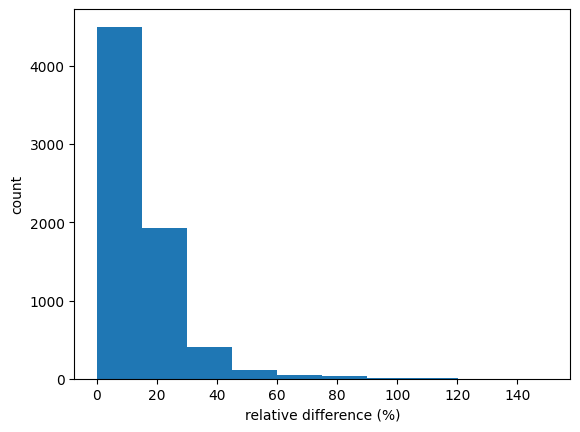

In [24]:
sorted_diffs = np.sort(abs(y_test - predictions.T) / y_test * 100)
plt.hist(sorted_diffs)
plt.xlabel('relative difference (%)')
plt.ylabel('count')
plt.show()

### Linearna regresija sa skrivenim slojevima i polinomijalno transformiranim značajkama

In [25]:
input_size = X_train_scaled_poly.shape[1]

input_shape = (input_size,)
hidden_layer_sizes = [64, 32, 16]
activation_functions = ['relu', 'sigmoid', 'relu']

neural_network = create_neural_network(input_shape, hidden_layer_sizes, activation_functions)

neural_network.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                7744      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 10369 (40.50 KB)
Trainable params: 10369 (40.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
neural_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
              loss='mse')

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5)

neural_network.fit(
    X_train_scaled_poly, y_train, 
    epochs=300, batch_size=1024, 
    validation_data=(X_val_scaled_poly, y_val),
    callbacks=[reduce_lr, early_stopping]
)

predictions = neural_network.predict(X_test_scaled_poly)

Epoch 1/300
22/22 [==============================] - 1s 10ms/step - loss: 351.4550 - val_loss: 93.9392 - lr: 0.0100
Epoch 2/300
22/22 [==============================] - 0s 4ms/step - loss: 85.3656 - val_loss: 70.2833 - lr: 0.0100
Epoch 3/300
22/22 [==============================] - 0s 4ms/step - loss: 62.1821 - val_loss: 51.3101 - lr: 0.0100
Epoch 4/300
22/22 [==============================] - 0s 4ms/step - loss: 47.0497 - val_loss: 41.6628 - lr: 0.0100
Epoch 5/300
22/22 [==============================] - 0s 4ms/step - loss: 39.0741 - val_loss: 35.6858 - lr: 0.0100
Epoch 6/300
22/22 [==============================] - 0s 4ms/step - loss: 34.0829 - val_loss: 31.7449 - lr: 0.0100
Epoch 7/300
22/22 [==============================] - 0s 4ms/step - loss: 30.2185 - val_loss: 28.6402 - lr: 0.0100
Epoch 8/300
22/22 [==============================] - 0s 4ms/step - loss: 27.3829 - val_loss: 26.3689 - lr: 0.0100
Epoch 9/300
22/22 [==============================] - 0s 4ms/step - loss: 25.1979 - val

In [27]:
predictions = predictions.reshape((predictions.shape[0]))
mse = mean_squared_error(y_test, predictions.T)
average_relative_difference = np.mean(abs(y_test - predictions.T) / y_test)
print(f'Average Relative Difference: {average_relative_difference}')
print(f'Mean Squared Error: {mse}')
print(f'R2_score = {r2_score(y_test, predictions)}')

Average Relative Difference: 0.1445955299477998
Mean Squared Error: 18.668362251644307
R2_score = 0.7813598308695546


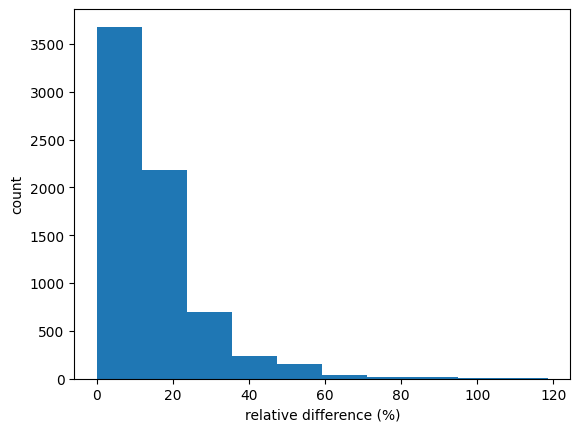

In [28]:
sorted_diffs = np.sort(abs(y_test - predictions.T) / y_test) * 100
plt.hist(sorted_diffs)
plt.xlabel('relative difference (%)')
plt.ylabel('count')
plt.show()

## Testiranje alternativnih pristupa

In [29]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost
import numpy as np

models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    SVR(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
]

param_grid = [
    {},  
    {'alpha': [0.01, 0.1, 1.0]},
    {'alpha': [0.01, 0.1, 1.0]},
    {'alpha': [0.01, 0.1, 1.0], 'l1_ratio': [0.1, 0.5, 0.9]},
    {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf']},
    {'max_depth': [3, 5, 7]},
    {'n_estimators': [100, 200, 300]},
    {'n_estimators': [20, 25, 30], 'max_depth': [5, 7, 9]},
]

best_models = []
for i, model in enumerate(models):
    grid_search = GridSearchCV(model, param_grid[i], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)

    model_name = model.__class__.__name__
    best_models.append((model_name, grid_search.best_estimator_))
    print(f"{model_name}:")
    print("Best parameters:", grid_search.best_params_)
    print("Best MSE score:", -1 * grid_search.best_score_)
    print()

LinearRegression:
Best parameters: {}
Best MSE score: 37.05612537227641

Ridge:
Best parameters: {'alpha': 0.01}
Best MSE score: 37.067124495129725

Lasso:
Best parameters: {'alpha': 0.01}
Best MSE score: 37.062039224295646

ElasticNet:
Best parameters: {'alpha': 0.01, 'l1_ratio': 0.9}
Best MSE score: 37.06281641754651

SVR:
Best parameters: {'C': 10.0, 'kernel': 'rbf'}
Best MSE score: 26.981562040995943

DecisionTreeRegressor:
Best parameters: {'max_depth': 7}
Best MSE score: 23.95440872347864

RandomForestRegressor:
Best parameters: {'n_estimators': 300}
Best MSE score: 14.72544651573044

GradientBoostingRegressor:
Best parameters: {'max_depth': 9, 'n_estimators': 30}
Best MSE score: 14.264676579932788



In [30]:
for name, best_model in best_models:
    predictions = best_model.predict(X_train_scaled)
    mse = mean_squared_error(y_train, predictions)
    average_relative_difference = np.mean(abs(y_train - predictions) / y_train)
    print(f"{name} on train dataset:")
    print(f'Average Relative Difference: {average_relative_difference}')
    print(f'Mean Squared Error: {mse}')
    print(f'R2_score = {r2_score(y_train, predictions)}')
    print()

LinearRegression on train dataset:
Average Relative Difference: 0.21171951866344046
Mean Squared Error: 36.94517270329782
R2_score = 0.5790374645880672

Ridge on train dataset:
Average Relative Difference: 0.21180806954080603
Mean Squared Error: 36.959300497416805
R2_score = 0.5788764889694156

Lasso on train dataset:
Average Relative Difference: 0.21199031858688436
Mean Squared Error: 36.99117638564835
R2_score = 0.5785132871287795

ElasticNet on train dataset:
Average Relative Difference: 0.21199445240689782
Mean Squared Error: 36.9907613803908
R2_score = 0.5785180158024503

SVR on train dataset:
Average Relative Difference: 0.1503413293815662
Mean Squared Error: 21.637021168525344
R2_score = 0.7534623707672896

DecisionTreeRegressor on train dataset:
Average Relative Difference: 0.16196642960683777
Mean Squared Error: 23.2166808110996
R2_score = 0.7354633338277057

RandomForestRegressor on train dataset:
Average Relative Difference: 0.048095777000826644
Mean Squared Error: 1.9916258

In [31]:
for name, best_model in best_models:
    predictions = best_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, predictions)
    average_relative_difference = np.mean(abs(y_test - predictions) / y_test)
    print(f"{name} on test dataset:")
    print(f'Average Relative Difference: {average_relative_difference}')
    print(f'Mean Squared Error: {mse}')
    print(f'R2_score = {r2_score(y_test, predictions)}')
    print()

LinearRegression on test dataset:
Average Relative Difference: 2.7064801565308736
Mean Squared Error: 5036.443960294177
R2_score = -57.98583627483111

Ridge on test dataset:
Average Relative Difference: 0.20657605434393833
Mean Squared Error: 36.45995682085744
R2_score = 0.5729881915539288

Lasso on test dataset:
Average Relative Difference: 0.20653568503498035
Mean Squared Error: 36.41608898892133
R2_score = 0.5735019629316539

ElasticNet on test dataset:
Average Relative Difference: 0.2065403649866773
Mean Squared Error: 36.41688878235121
R2_score = 0.573492595909072

SVR on test dataset:
Average Relative Difference: 0.1708410134566895
Mean Squared Error: 26.12130690911599
R2_score = 0.6940724160195493

DecisionTreeRegressor on test dataset:
Average Relative Difference: 0.16025879033722043
Mean Squared Error: 23.452010282339078
R2_score = 0.7253346905603396

RandomForestRegressor on test dataset:
Average Relative Difference: 0.12881714217783946
Mean Squared Error: 14.521581532043989


### Testiranje alternativnih pristupa sa polinomijalno transformiranim značajkama

In [32]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost
import numpy as np

models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    SVR(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
]

param_grid = [
    {},  
    {'alpha': [0.01, 0.1, 1.0]},
    {'alpha': [0.01, 0.1, 1.0]},
    {'alpha': [0.01, 0.1, 1.0], 'l1_ratio': [0.1, 0.5, 0.9]},
    {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf']},
    {'max_depth': [3, 5, 7]},
    {'n_estimators': [100, 200, 300]},
    {'n_estimators': [20, 25, 30], 'max_depth': [5, 7, 9]},
]

best_models_on_poly = []
for i, model in enumerate(models):
    grid_search = GridSearchCV(model, param_grid[i], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled_poly, y_train)

    model_name = model.__class__.__name__
    best_models_on_poly.append((model_name, grid_search.best_estimator_))
    print(f"{model_name}:")
    print("Best parameters:", grid_search.best_params_)
    print("Best MSE score:", -1 * grid_search.best_score_)
    print()

LinearRegression:
Best parameters: {}
Best MSE score: 29.53214628722558

Ridge:
Best parameters: {'alpha': 0.1}
Best MSE score: 29.502524647409395

Lasso:
Best parameters: {'alpha': 0.01}
Best MSE score: 29.892185000363458

ElasticNet:
Best parameters: {'alpha': 0.01, 'l1_ratio': 0.9}
Best MSE score: 29.995022648019006

SVR:
Best parameters: {'C': 10.0, 'kernel': 'rbf'}
Best MSE score: 22.650160372597842

DecisionTreeRegressor:
Best parameters: {'max_depth': 7}
Best MSE score: 19.118562861480164

RandomForestRegressor:
Best parameters: {'n_estimators': 300}
Best MSE score: 16.576495071736183

GradientBoostingRegressor:
Best parameters: {'max_depth': 7, 'n_estimators': 30}
Best MSE score: 16.361649499659215



In [33]:
for name, best_model in best_models_on_poly:
    predictions = best_model.predict(X_train_scaled_poly)
    mse = mean_squared_error(y_train, predictions)
    average_relative_difference = np.mean(abs(y_train - predictions) / y_train)
    print(f"{name} on train dataset:")
    print(f'Average Relative Difference: {average_relative_difference}')
    print(f'Mean Squared Error: {mse}')
    print(f'R2_score = {r2_score(y_train, predictions)}')
    print()

LinearRegression on train dataset:
Average Relative Difference: 0.18807096026283146
Mean Squared Error: 29.17801364794456
R2_score = 0.6675384169356902

Ridge on train dataset:
Average Relative Difference: 0.1880907543832698
Mean Squared Error: 29.17763314484293
R2_score = 0.6675427524831697

Lasso on train dataset:
Average Relative Difference: 0.1896418537175998
Mean Squared Error: 29.71066797296579
R2_score = 0.6614692203735355

ElasticNet on train dataset:
Average Relative Difference: 0.1900419437681835
Mean Squared Error: 29.80062505777326
R2_score = 0.6604442268567116

SVR on train dataset:
Average Relative Difference: 0.1449010306243352
Mean Squared Error: 19.65537977384492
R2_score = 0.7760416883003607

DecisionTreeRegressor on train dataset:
Average Relative Difference: 0.140178206398271
Mean Squared Error: 17.56347042522961
R2_score = 0.7998774264715459

RandomForestRegressor on train dataset:
Average Relative Difference: 0.05011528223636337
Mean Squared Error: 2.2528339683241

In [34]:
for name, best_model in best_models_on_poly:
    predictions = best_model.predict(X_test_scaled_poly)
    mse = mean_squared_error(y_test, predictions)
    average_relative_difference = np.mean(abs(y_test - predictions) / y_test)
    print(f"{name} on test dataset:")
    print(f'Average Relative Difference: {average_relative_difference}')
    print(f'Mean Squared Error: {mse}')
    print(f'R2_score = {r2_score(y_test, predictions)}')
    print()

LinearRegression on test dataset:
Average Relative Difference: 0.18210702257919034
Mean Squared Error: 29.00344660881981
R2_score = 0.6603173654743248

Ridge on test dataset:
Average Relative Difference: 0.1821046993460745
Mean Squared Error: 28.994326887748347
R2_score = 0.6604241738451186

Lasso on test dataset:
Average Relative Difference: 0.18293332979368454
Mean Squared Error: 29.242901058244946
R2_score = 0.6575129222877385

ElasticNet on test dataset:
Average Relative Difference: 0.183338369949162
Mean Squared Error: 29.339216233004663
R2_score = 0.6563848979964036

SVR on test dataset:
Average Relative Difference: 0.15364567244212862
Mean Squared Error: 21.862951962804555
R2_score = 0.743945427541864

DecisionTreeRegressor on test dataset:
Average Relative Difference: 0.14151725660236958
Mean Squared Error: 18.59823093508553
R2_score = 0.7821811949885417

RandomForestRegressor on test dataset:
Average Relative Difference: 0.13498204694644347
Mean Squared Error: 16.4311178654802

### Devijacija srednje kvadratne greške (MSE) 

In [35]:
from sklearn.model_selection import cross_val_score, KFold

X, y = X_numeric, merged_df[target_column]

input_size = X.shape[1]

input_shape = (input_size,)  # Replace input_size with the actual size of your input features
hidden_layer_sizes = [64, 32, 16]  # Example: Two hidden layers with 64 and 32 units

activation_functions = ['relu', 'sigmoid', 'relu']


kf = KFold(n_splits=8, shuffle=True, random_state=39)
    
scores_per_fold = []
for train_indices, test_indices in kf.split(X):
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    neural_network_dev = create_neural_network(input_shape, hidden_layer_sizes, activation_functions)
    neural_network_dev.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5)
    neural_network_dev.fit(
        X_train_scaled, y_train, 
        epochs=300, batch_size=1024, 
        validation_data=(X_test_scaled, y_test),
        callbacks=[reduce_lr, early_stopping]
    )
        
    scores_per_fold.append(mean_squared_error(y_test, neural_network_dev.predict(X_test_scaled)))
    


Epoch 1/300
31/31 [==============================] - 1s 10ms/step - loss: 691.9472 - val_loss: 585.8790 - lr: 0.0010
Epoch 2/300
31/31 [==============================] - 0s 4ms/step - loss: 504.7539 - val_loss: 412.1212 - lr: 0.0010
Epoch 3/300
31/31 [==============================] - 0s 4ms/step - loss: 335.5839 - val_loss: 252.5517 - lr: 0.0010
Epoch 4/300
31/31 [==============================] - 0s 4ms/step - loss: 192.6676 - val_loss: 137.7855 - lr: 0.0010
Epoch 5/300
31/31 [==============================] - 0s 4ms/step - loss: 110.1443 - val_loss: 92.3515 - lr: 0.0010
Epoch 6/300
31/31 [==============================] - 0s 5ms/step - loss: 83.7777 - val_loss: 80.8662 - lr: 0.0010
Epoch 7/300
31/31 [==============================] - 0s 3ms/step - loss: 75.4525 - val_loss: 74.3022 - lr: 0.0010
Epoch 8/300
31/31 [==============================] - 0s 4ms/step - loss: 68.4181 - val_loss: 67.1415 - lr: 0.0010
Epoch 9/300
31/31 [==============================] - 0s 4ms/step - loss: 60.81

In [36]:
print(f"Average MSE: {np.mean(scores_per_fold)}")
print(f"MSE Standard Deviation: {np.std(scores_per_fold)}")

Average MSE: 16.92298600444407
MSE Standard Deviation: 0.7097153407729242
